In [1]:
import time
start_time=time.time()

In [2]:
from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np
from scipy.fftpack import fft
import pandas as pd
import math
import sys
import os
from PIL import Image
import seaborn as sns
from scipy import interpolate
from sabreMod import sosf,sosfn

Sigma

In [3]:
#ARCHIVO
reg='604'
FitsFile= 'Obs/TAURUS.604.Ha.Sigma'
hdul=fits.open(FitsFile + '.fits')

Text(0.5, 1.0, 'H$_{α}$ σ$_{disp}$')

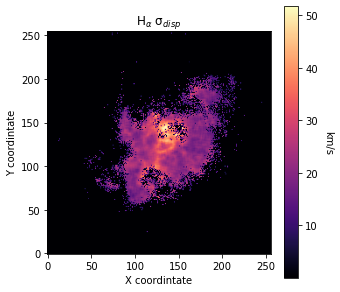

In [4]:
#IMAGEN S
fig, ax = plt.subplots(figsize=(5, 5))
image_data=hdul[0].data
plt.imshow(image_data, cmap='magma')
ax.set_xlabel('X coordintate')
ax.set_ylabel('Y coordintate')
cbar = plt.colorbar()
cbar.set_label('km/s', rotation=270, labelpad=15)  
plt.gca().invert_yaxis()
plt.title('H$_{α}$ σ$_{disp}$')
#plt.savefig('TAURUS/'+reg+'SH.png')

In [5]:
#TABLA DATOS
sig=hdul[0].data
df=pd.DataFrame(sig)

In [6]:
df=df.reindex(index=df.index[::-1])

In [7]:
dsig=df.stack().reset_index().rename(columns={'level_0':'Y', 'level_1':'X', 0:'Sig'})
dsig.describe()

,Y,X,Sig
count,65536.000000,65536.000000,6.553600e+04
mean,127.500000,127.500000,3.607881e+00
std,73.900834,73.900834,8.906863e+00
min,0.000000,0.000000,1.291134e-08
25%,63.750000,63.750000,1.291134e-08
50%,127.500000,127.500000,1.291134e-08
75%,191.250000,191.250000,1.291134e-08
max,255.000000,255.000000,5.164933e+01


In [8]:
#dsig.Sig=dsig.Sig.values[::-1]
#dsig.describe()

Brillo emisión

In [9]:
#ARCHIVO
FitsFile= 'Obs/TAURUS.604.Ha.Flux'
hdul=fits.open(FitsFile + '.fits')

Text(0.5, 1.0, 'H$_{α}$ Flux')

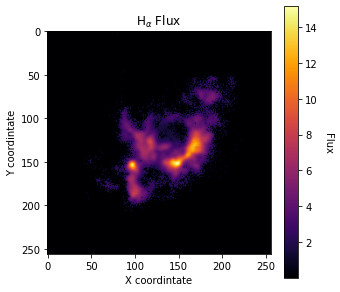

In [10]:
#IMAGEN
fig, ax = plt.subplots(figsize=(5, 5))


image_data=hdul[0].data
plt.imshow(image_data, cmap='inferno')
ax.set_xlabel('X coordintate')
ax.set_ylabel('Y coordintate')
cbar = plt.colorbar()
cbar.set_label('Flux', rotation=270, labelpad=15)  
plt.title('H$_{α}$ Flux')

#plt.savefig('TAURUS/'+reg+'FH.png')

In [11]:
#TABLA DATOS
flx=hdul[0].data
df=pd.DataFrame(flx)

In [12]:
dffx=df.stack().reset_index().rename(columns={'level_0':'Y', 'level_1':'X', 0:'I'})
dffx.describe()

,Y,X,I
count,65536.000000,65536.000000,6.553600e+04
mean,127.500000,127.500000,5.889378e-01
std,73.900834,73.900834,1.665959e+00
min,0.000000,0.000000,3.787646e-09
25%,63.750000,63.750000,3.787646e-09
50%,127.500000,127.500000,3.787646e-09
75%,191.250000,191.250000,3.787646e-09
max,255.000000,255.000000,1.515018e+01


Velocidad Radial

In [13]:
#ARCHIVO
FitsFile= FitsFile= 'Obs/TAURUS.604.Ha.RV'
#FitsFile= 'n604halphasigma'
hdul=fits.open(FitsFile + '.fits')

Text(0.5, 1.0, 'H$_{α}$ Radial Velocity')

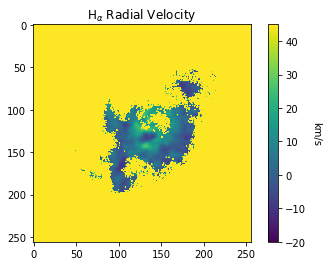

In [14]:
#IMAGEN
image_data=hdul[0].data
plt.imshow(image_data, cmap='viridis')
ax.set_xlabel('X coordintate')
ax.set_ylabel('Y coordintate')
cbar = plt.colorbar()
cbar.set_label('km/s', rotation=270, labelpad=15)  
plt.clim(-20,45) 
plt.title('H$_{α}$ Radial Velocity')
#plt.savefig('TAURUS/'+reg+'RVH.png')

In [15]:
#TABLA DATOS
vel=hdul[0].data
df=pd.DataFrame(vel)
#dfv=df.stack()
#dfv

In [16]:
dfvr=df.stack().reset_index().rename(columns={'level_0':'Y', 'level_1':'X', 0:'RV'})
dfvr.describe()

,Y,X,RV
count,65536.000000,65536.000000,65536.000000
mean,127.500000,127.500000,335.500406
std,73.900834,73.900834,139.319611
min,0.000000,0.000000,-16.693176
25%,63.750000,63.750000,393.980011
50%,127.500000,127.500000,393.980011
75%,191.250000,191.250000,393.980011
max,255.000000,255.000000,393.980011


Tabla General

In [17]:
data=dfvr
data['I']=dffx.I
data['Sig']=dsig.Sig
data.describe()

,Y,X,RV,I,Sig
count,65536.000000,65536.000000,65536.000000,6.553600e+04,6.553600e+04
mean,127.500000,127.500000,335.500406,5.889378e-01,3.607881e+00
std,73.900834,73.900834,139.319611,1.665959e+00,8.906863e+00
min,0.000000,0.000000,-16.693176,3.787646e-09,1.291134e-08
25%,63.750000,63.750000,393.980011,3.787646e-09,1.291134e-08
50%,127.500000,127.500000,393.980011,3.787646e-09,1.291134e-08
75%,191.250000,191.250000,393.980011,3.787646e-09,1.291134e-08
max,255.000000,255.000000,393.980011,1.515018e+01,5.164933e+01


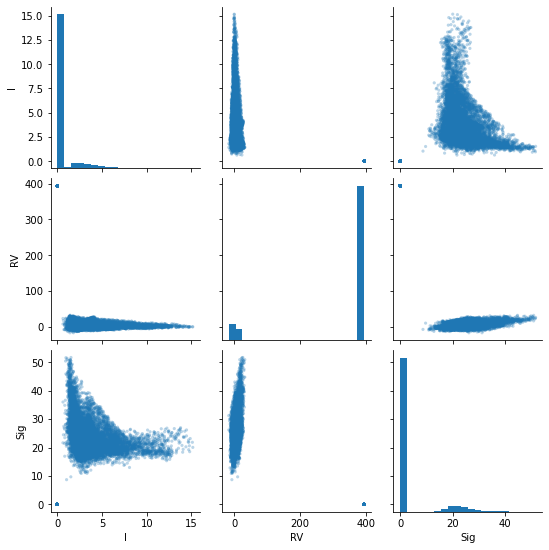

In [18]:
sns.pairplot(data, 
             vars=["I","RV","Sig"], 
             diag_kind='hist',  
             plot_kws=dict(alpha=0.3, s=10, edgecolor='none'),
             diag_kws=dict(bins=20),
            )

Ajuste de datos

In [19]:
mI=(data.I>data.I.mean()+0.5*data.I.std())&(data.Sig>data.Sig.mean()+0.5*data.Sig.std())
data=data[mI]

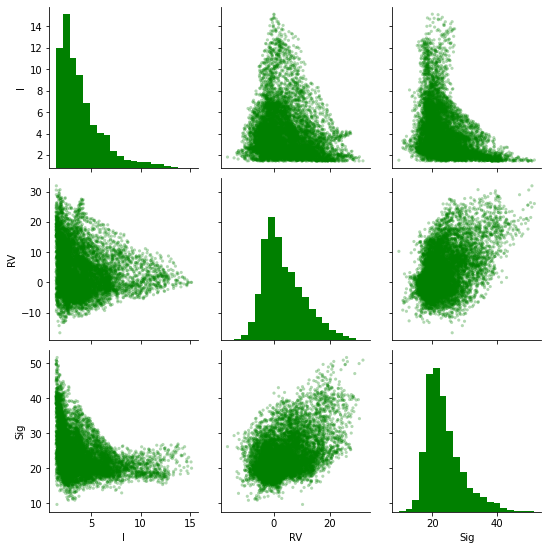

In [20]:
sns.pairplot(data, 
             vars=["I","RV","Sig"], 
             diag_kind='hist',  
             plot_kws=dict(alpha=0.3, s=10, edgecolor='none',color='green'),
             diag_kws=dict(bins=20, color="green"),
            )

#plt.savefig('TAURUS/'+reg+'CorrlHA.png')

In [21]:
data.describe()

,Y,X,RV,I,Sig
count,9510.000000,9510.000000,9510.000000,9510.000000,9510.000000
mean,130.015247,138.798633,3.564254,4.017141,23.751665
std,33.245833,35.100884,7.391004,2.307828,5.653767
min,50.000000,45.000000,-16.693176,1.422287,9.705013
25%,106.000000,109.000000,-1.850128,2.393386,19.786402
50%,131.000000,139.000000,1.922028,3.357099,22.443563
75%,155.000000,169.000000,8.060150,4.908373,26.360056
max,206.000000,222.000000,32.009949,15.150179,51.649326


In [22]:
data.sem()

Y      0.340916
X      0.359938
RV     0.075790
I      0.023665
Sig    0.057976
dtype: float64

Text(0.5, 1.0, 'H$_{α}$ Flux')

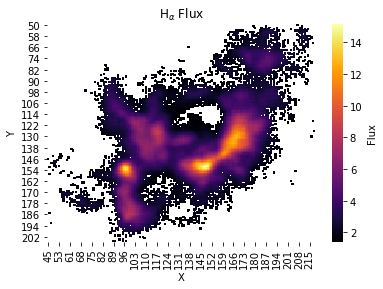

In [23]:
datal=data.copy()
#datal.I=np.log10(datal.I)
datal.X=datal.X.astype(int)
dataH_f=(datal.round(2)).pivot(index='Y', columns='X', values='I')
#fig, ax = plt.subplots(figsize=(17, 4))
sns.heatmap(dataH_f, cmap="inferno",xticklabels='auto',cbar_kws={'label': 'Flux'})
plt.title('H$_{α}$ Flux')
#plt.savefig('TAURUS/Imgs/A/'+reg+'FH.png')

Text(0.5, 1.0, 'H$_{α}$ Radial Velocity')

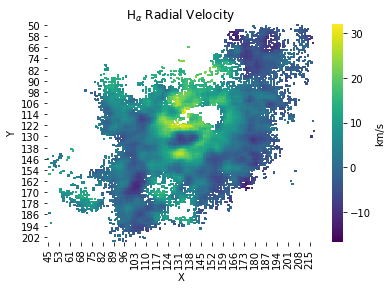

In [24]:
datal=data.copy()
dataH_rv=(datal.round(2)).pivot(index='Y', columns='X', values='RV')
sns.heatmap(dataH_rv, cmap="viridis",cbar_kws={'label': 'km/s'})
plt.title('H$_{α}$ Radial Velocity')
#plt.savefig('TAURUS/Imgs/A/'+reg+'RVH.png')

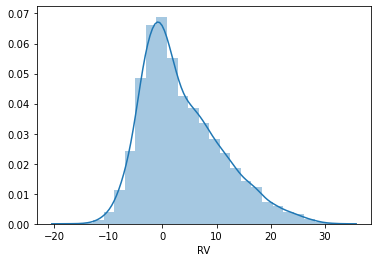

In [25]:
sns.distplot(data.RV,bins=25)


Text(0.5, 1.0, 'H$_{α}$ σ$_{disp}$')

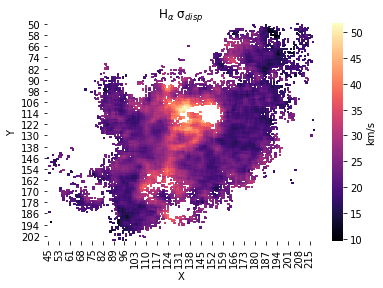

In [26]:
datal=data.copy()
dataH_s=(datal.round(2)).pivot(index='Y', columns='X', values='Sig')
sns.heatmap(dataH_s, cmap="magma",cbar_kws={'label': 'km/s'})
plt.title('H$_{α}$ σ$_{disp}$')
#plt.savefig('TAURUS/Imgs/A/'+reg+'SH.png')

In [27]:
#data.Sig

In [28]:
data.Sig=(data.Sig**2-9.87**2-1.73**2)**0.5

C:\Users\ZAINTEL2\anaconda3\lib\site-packages\pandas\core\generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


Text(0, 0.5, '$σ_{disp}$ [km/s]')

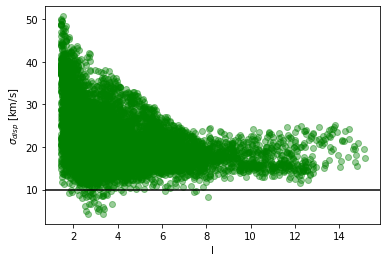

In [29]:
fig, ax = plt.subplots()
plt.scatter(data.I,data.Sig, alpha=0.4, color='green')
#plt.title(LineN[i])
plt.axhline(y=10, color='k', linestyle='-')
#plt.axhline(y=21, color='k', linestyle='--')
#plt.axhline(y=23.5, color='k', linestyle='-.')
#plt.axhline(y=13.6, color='k', linestyle=':')



ax.set_xlabel('I')
ax.set_ylabel('$σ_{disp}$ [km/s]')

In [30]:
pc=1.05

1.0


[None, None]

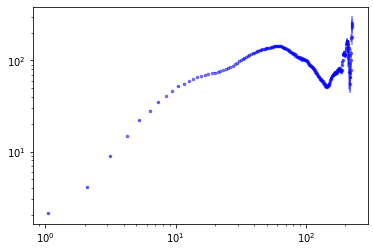

In [31]:
SF=sosf(data)
SF.Lag=SF.Lag*pc

fig,ax=plt.subplots()

ax.errorbar(SF.Lag,SF.Nmqvd, yerr=SF.ErrY, marker='.', fmt=' ',color="blue", ecolor="blue",
                     alpha=0.5, markersize=5)

ax.set(xscale='log',yscale='log')

In [32]:
x=SF['Lag']
y=SF['Nmqvd']-(data["RV"].std())**2
tck=interpolate.splrep(x,y,s=0)
grid=np.linspace(x.min(),x.max(),num=len(x))
ynew=interpolate.splev(grid,tck,der=0)
inter=pd.DataFrame([grid,ynew]).T
SFr=interpolate.sproot(tck)
SFr

array([ 11.22523708, 139.14742842, 149.70658275])

In [33]:
s=SFr[0]

In [34]:
ss=np.round((data['RV'].std())**2,2)

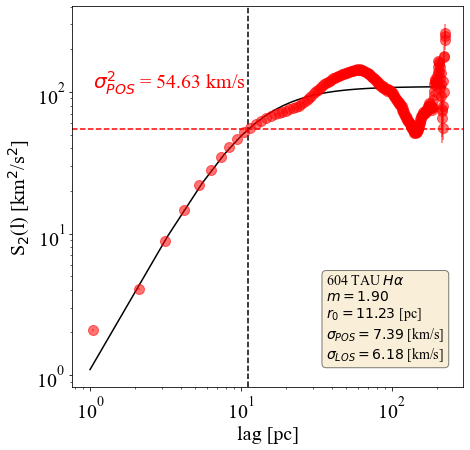

In [37]:
fig,ax=plt.subplots(figsize=(7,7))

ax.errorbar(SF.Lag,SF.Nmqvd, yerr=SF.ErrY, marker='.', fmt=' ',color="red", ecolor="red",
                     alpha=0.55, markersize=20)

ax.set(xlabel='lag [pc]', ylabel='S$_{2}$(l) [km$^{2}$/s$^{2}$]')

plt.axhline(y=ss, color='r', linestyle='--')
ax.text(0.25, 0.8,'$σ_{POS}^{2}$ = '+str(ss)+' km/s', ha='center', va='center', transform=ax.transAxes, color='r')


plt.axvline(x=s, color='k', linestyle='--')

lo=s

n=1.9

x=np.linspace(int(SF.Lag.min()),int(SF.Lag.max()),100)
c=1/(1+(x/lo)**n)

y=2*(1-c)*ss

plt.loglog(x,y,color='k', linestyle='-')


textstr = '\n'.join(('604 TAU ' r'$Hα$' ,r'$m=%.2f$'%n, r'$r_{0}=%.2f$' % s+' [pc]',
                     r'$σ_{POS}=%.2f$' % (data["RV"].std()) + ' [km/s]' , r'$σ_{LOS}=%.2f$'%(data["Sig"].std()) + ' [km/s]' )) 

props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
ax.text(0.65, .3, textstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)

plt.rcParams["font.family"]="Times New Roman"
plt.rcParams["font.size"]="20"

#ax.set_xlim(1, 250)
#ax.set_ylim(1, 750)

#fig.savefig('Img//'+samples[0][i]+'.pdf')

In [36]:
print("--- %s seconds ---" % (time.time()-start_time))

--- 1100.2791819572449 seconds ---
